# Accessing larlite Data Products (C++ Classes and Their Functions) In Python, and Storing Actual C++ Classes in a DataFrame and Calling their Public Functions!
#### Note: you need to "source config/setup.sh" from your local larlite install in your terminal before typing "jupyter notebook blahblah.ipynb" for this to work. I haven't been able to effectively source this from within a jupyter notebook.

In [1]:
# These imports are actually NOT NEEDED if you already know the name of
# the ttree within the root file.
from ROOT import TFile, TTree

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

%matplotlib inline

In [2]:
# Sample "litescanned" file that I happen to have lying around
myfile =  '/Users/davidkaleko/Data/larlite/mcc7_022316/'
myfile += 'scan_prod_pi0_0-1.0GeV_isotropic_v1/larlite_mcinfo_all.root'

In [3]:
f = TFile(myfile,"READ")
# Let's look at what's in the file:
print "Things stored in this file are:"
print [mykey.GetName() for mykey in f.GetListOfKeys()]
print
print "# of entries (# of events) stored in the mcshower tree is %d." % \
    f.mcshower_mcreco_tree.GetEntries()

Things stored in this file are:
['larlite_id_tree', 'gtruth_generator_tree', 'mctruth_corsika_tree', 'mctruth_generator_tree', 'mcflux_generator_tree', 'mcshower_mcreco_tree', 'mctrack_mcreco_tree', 'potsummary_generator_tree']

# of entries (# of events) stored in the mcshower tree is 5050.


#### Here I loop over the MCShower TTree, and for each event (each TTree entry) I store both the _actual MCShower object_ and the MCShower's energy in a dataframe for later analysis.

In [4]:
# The only way I've gotten this to work is to "copy" the larlite object (the MCShower)
# when putting it into a DataFrame. Otherwise things don't work... If you can improve
# upon this, please do!
import copy

mydata = []
for ientry in xrange(f.mcshower_mcreco_tree.GetEntries()):
    # You must do a "TTree.GetEntry" for each event
    blah = f.mcshower_mcreco_tree.GetEntry(ientry)
    
    # The ttree's "branch" with the same name is exactly what
    # you are used to seeing as "event_mcshower" in larlite analysis code
    ev_mcs = f.mcshower_mcreco_tree.mcshower_mcreco_branch
    
    # The size of ev_mcshower is the number of mcshowers in this specific event.
    # Here I just require that the event does indeed have at least one MCShower
    if not ev_mcs.size(): continue
        
    # There are many ways to make a dataframe, but one I use is to create a
    # list of tuples. The length of the list will be the number of rows in the
    # resulting dataframe, and the length of each tuple in the list will be
    # the number of columns in the resulting dataframe.
    # Note for the actual MCShower object, I use the "copy" function from
    # the "copy" module.
    mydata.append( ( copy.copy(ev_mcs.at(0)), ev_mcs.at(0).DetProfile().E() ) )

In [5]:
# Closing the file for good measure. We already have all the info stored in "mydata"
f.Close()

In [6]:
# This is the dataframe function that turns the above list-of-tuples into a dataframe.
# Again there are probably better ways to do this (maybe that don't even involve a
# for-loop!!)
df = pd.DataFrame.from_records(mydata)

# Here I'm just naming the columns for my convenience.
df.columns = ['MCShower0', 'Shower0Energy']

In [7]:
df.head()

,MCShower0,Shower0Energy
0,<ROOT.larlite::mcshower object at 0x7f8ba7441400>,145.217978
1,<ROOT.larlite::mcshower object at 0x7f8ba73fde00>,0.000000
2,<ROOT.larlite::mcshower object at 0x7f8ba73ff000>,0.888849
3,<ROOT.larlite::mcshower object at 0x7f8ba2f86e00>,148.693843
4,<ROOT.larlite::mcshower object at 0x7f8ba2f87400>,583.193069


In [8]:
# I'm copying the Shower0Energy variable into a numpy array
s0E_fromDF = np.array( df['Shower0Energy'] )

# Here I define a function to get the energy from the MCShower object:
def getE(mcshower_object):
    return mcshower_object.DetProfile().E()

# Here I vectorize this function because I am going to be calling it once
# per row in my dataframe, and I don't want to do a for-loop.
# Vectorize is faster!
getE_vectorized = np.vectorize(getE)

# Here I use the vectorized function to get the MCShower energy from
# the actual MCShower objects stored in the dataframe.
# It should be the same thing as "Shower0Energy"!
s0E_fromDataProduct = getE_vectorized(df['MCShower0'])

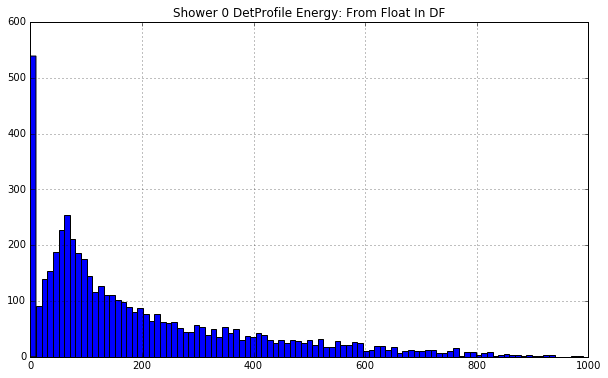

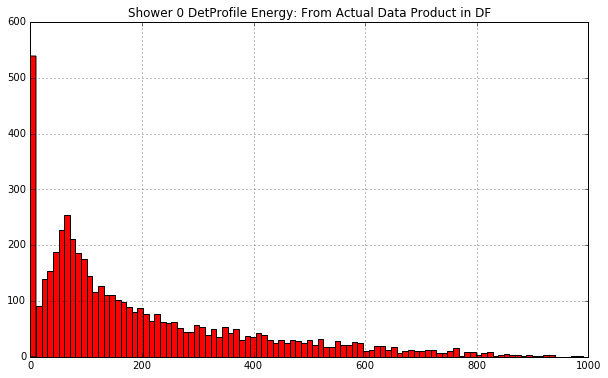

In [9]:
plt.figure(figsize=(10,6))
plt.grid(True) #ALWAYS TRUE
mybins = np.linspace(0,1000,100)
plt.title("Shower 0 DetProfile Energy: From Float In DF")
poop = plt.hist(s0E_fromDF,bins=mybins,color='blue')
plt.figure(figsize=(10,6))
plt.grid(True) #ALWAYS TRUE
plt.title("Shower 0 DetProfile Energy: From Actual Data Product in DF")
poop = plt.hist(s0E_fromDataProduct,bins=mybins,color='red')